In [11]:
# Parameters to set to run this notebook

# Initialize helpers.
import numpy as np
import project_path
from model.data_accessor import get_data_file_abs_path
from model.neuron_metadata import *
from model.neural_model import NeuralModel
import model.init_conds as init_conds

neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
N = neuron_metadata_collection.get_size()
model = NeuralModel(neuron_metadata_collection)

# The step amplitudes in nA. Each amplitude will be run for step_duration
start_amp_nA = 6.7
amp_delta_nA = 0.018
peak_amp_nA = start_amp_nA + amp_delta_nA * 4

# Ascending steps only.
# step_amplitudes_nA =np.arange(start_amp_nA, peak_amp_nA-amp_delta_nA/2, amp_delta_nA)

step_amplitudes_nA = [start_amp_nA,
                      start_amp_nA + amp_delta_nA,
                      start_amp_nA + amp_delta_nA *1.5,
                      start_amp_nA + amp_delta_nA *2]

# How many seconds to run each step for. This should be long enough for stability to be observed.
step_durations_s = np.array([2, 2, 1, 1,])

# Uncomment if you want stairway
"""
step_amplitudes_nA = np.concatenate((np.arange(start_amp_nA, peak_amp_nA-amp_delta_nA/2, amp_delta_nA), \
                                     np.arange(peak_amp_nA, start_amp_nA-amp_delta_nA/2, -amp_delta_nA)), axis=None)

step_durations_s = [1] * len(step_amplitudes_nA)
"""

# neurons_to_stimulate = ["PLML", "PLMR"]
key_neuron = "AWAR"
neurons_to_stimulate = [key_neuron]

# Initial condition
# If you want a fixed-seed initial condition, uncomment the line below.
# np.random.seed(0)
# init_conds = 10**(-4)*np.random.normal(0, 0.94, 2*N)
init_cond_seed = 11
initial_conds = init_conds.generate_init_cond_with_seed(
    model, key_neuron, start_amp_nA, init_cond_seed)

enable_caching = False

In [12]:
# Validate parameters
if len(step_durations_s) != len(step_amplitudes_nA):
  raise Exception("Step durations size %d doesn't match step amplitudes %d"
        % (len(step_durations_s), len(step_amplitudes_nA)))

is_const_step_duration = sum(np.array(step_durations_s) == step_durations_s[0]) == len(step_durations_s)
if is_const_step_duration:
  step_duration_timesteps = int(step_durations_s[0] / model.dt)
if enable_caching and not is_const_step_duration:
  raise Exception("Caching is NOT suported for varying step_durations")

In [13]:
# Setup the model
from util.plot_util import *
import os
import pickle

"""
neurons_to_observe = NeuronMetadataCollection.create_lr_names_from_base([
  "AWA"
])
"""

# Times when step values change
step_timechanges_s = np.cumsum(step_durations_s) - step_durations_s[0]

# neurons_to_observe = ["PLML", "PLMR"]
neurons_to_observe = ["AWAR"]

model.init_conds = initial_conds

# Set I_inj_i(t)

def time_to_I_ext_fun(t):
  # Find last index of timechanges where current time is greater than t
  amp_i = max(0, np.searchsorted(step_timechanges_s, t) - 1)
  amp = step_amplitudes_nA[amp_i]
  cur_I_ext = np.zeros(N)
  for neuron in neurons_to_stimulate:
    neuron_id = neuron_metadata_collection.get_id_from_name(neuron)
    cur_I_ext[neuron_id] = amp
  return cur_I_ext

# These are timesteps when I_ext changes
t_changes_I_ext = step_timechanges_s.tolist()
model.set_I_ext(time_to_I_ext_fun, t_changes_I_ext)

model.init_kunert_2017()

simul_timesteps = int(sum(step_durations_s) / model.dt)

In [14]:
# Run the model. Or not, if cached result already exists
# Cache file is about ~1MB for 1 second.

cache_key = "%d_%.2f_%.2f_%.2f_%s" % \
  (step_durations_s[0], start_amp_nA, peak_amp_nA, amp_delta_nA, "_".join(neurons_to_stimulate))
cache_path = "../local_results/exp_CHANGING_STEP_AWA/" + cache_key

v_normalized_mat = []
if enable_caching and os.path.isfile(cache_path):
  print("Loading saved results from pickle file {}".format(cache_path))
  with open(cache_path, "rb") as f:
    (v_mat, v_normalized_mat) = pickle.load(f)
else:
  (v_mat, s_mat, v_normalized_mat) = model.run(simul_timesteps)
  if enable_caching:
    # Update cache
    with open(cache_path, "wb") as f:
      pickle.dump((v_mat, v_normalized_mat), f)

Timestep 0 out of 600
Timestep 100 out of 600
Timestep 200 out of 600
Timestep 300 out of 600
Timestep 400 out of 600
Timestep 500 out of 600
Total runtime = 1.32s


# Plot stimulus

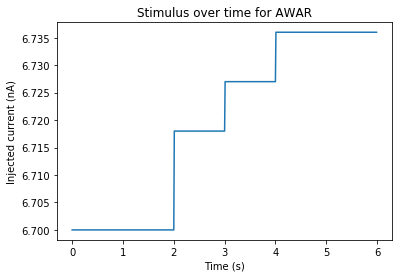

In [15]:
times = np.array(np.arange(0, simul_timesteps * model.dt, model.dt))

awar_index = neuron_metadata_collection.get_id_from_name("AWAR")
amps = [time_to_I_ext_fun(time)[awar_index] for time in times]
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(times, amps)
ax.set_title("Stimulus over time for AWAR")
ax.set_ylabel("Injected current (nA)")
ax.set_xlabel("Time (s)")
_ = _

# Plot potentials of selected neurons

/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


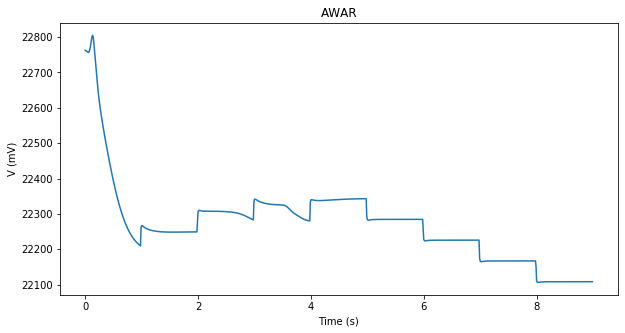

In [6]:
# %matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
plot_potentials(
  neuron_names_to_show = neurons_to_observe,
  dynamics = v_mat,
  is_normalized_v = False,
  dt = model.dt,
  neuron_metadata_collection = neuron_metadata_collection,
  fig_axes = [ax])
fig.show()

/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


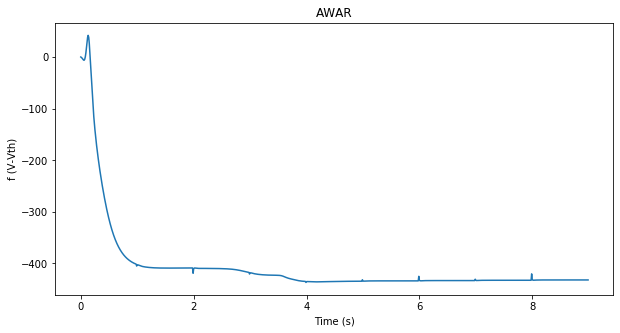

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
plot_potentials(
  neuron_names_to_show = neurons_to_observe,
  dynamics = v_normalized_mat,
  is_normalized_v = True,
  dt = model.dt,
  neuron_metadata_collection = neuron_metadata_collection,
  fig_axes = [ax])
fig.show()

# Plot summarized dynamics per neuron class

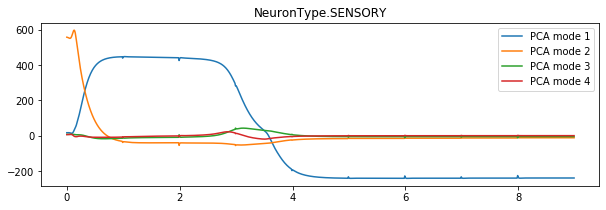

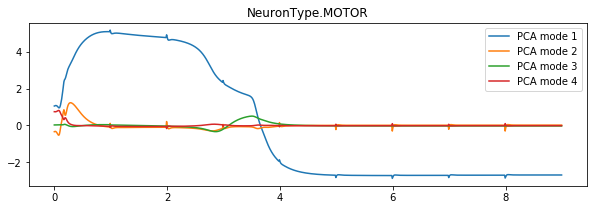

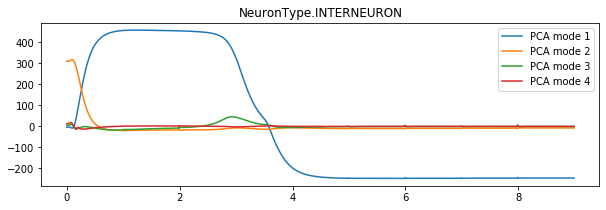

In [8]:
plot_pcas(v_normalized_mat, model.dt, neuron_metadata_collection)

# Bifurcation plot

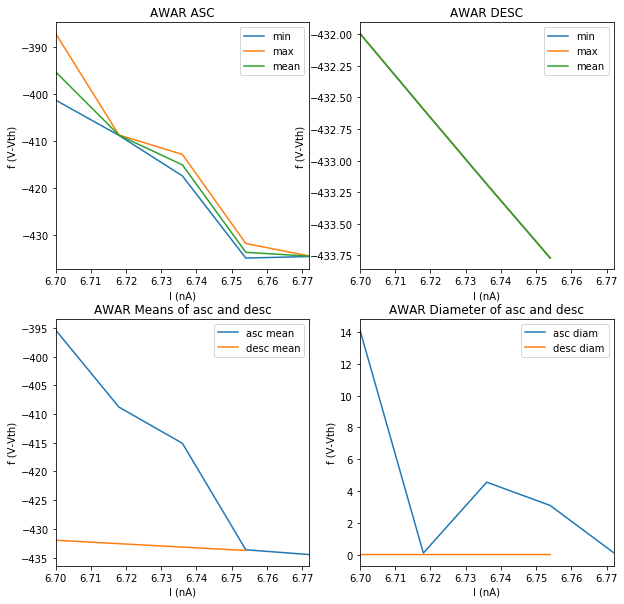

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
if not is_const_step_duration:
  raise Exception("Bifurcation plot doesn't support variable step durations yet")
# Also, this currently only works for stairway stimulus
create_changing_step_bifurcation_plot(
    neurons_to_observe = neurons_to_observe,
    dynamics = v_normalized_mat,
    is_normalized_v = True,
    step_amps_nA = step_amplitudes_nA,
    start_amp_nA = start_amp_nA,
    peak_amp_nA = peak_amp_nA,
    amp_delta_nA = amp_delta_nA, 
    step_duration_timesteps = step_duration_timesteps,
    neuron_metadata_collection = neuron_metadata_collection,
    fig_axes = {key_neuron: [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]})

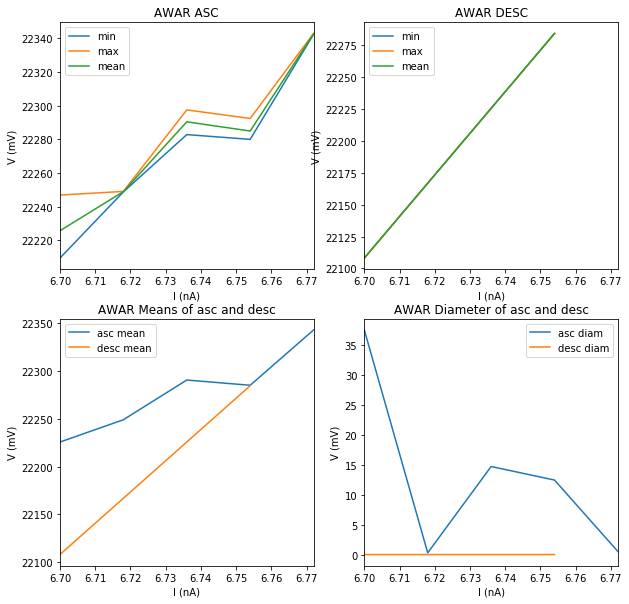

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
create_changing_step_bifurcation_plot(
    neurons_to_observe = neurons_to_observe,
    dynamics = v_mat,
    is_normalized_v = False,
    step_amps_nA = step_amplitudes_nA,
    start_amp_nA = start_amp_nA,
    peak_amp_nA = peak_amp_nA,
    amp_delta_nA = amp_delta_nA, 
    step_duration_timesteps = step_duration_timesteps,
    neuron_metadata_collection = neuron_metadata_collection,
    fig_axes = {key_neuron: [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]})